## RLlib continúa

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR) # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# HIDDEN
from ray.rllib.algorithms.ppo import PPO, PPOConfig

#### Características de RLlib

- Hasta ahora hemos visto el entrenamiento, la evaluación y la "predicción" con RLlib.
- A continuación exploraremos algunas características más:
   - Configuraciones de algoritmos
   - Guardar/restaurar modelos
   - Interpretación de políticas estocásticas

#### Configuraciones del algoritmo

¿Recuerdas este código?

``python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
ppo = PPO(env="FrozenLake-v1", config=ppo_config)
```

Anteriormente, hemos ocultado el `ppo_config`. Ahora profundizaremos en él.

In [4]:
ppo_config = PPOConfig()

In [5]:
# HIDDEN - this shows up in module 5 instead
# The number of options is way too many to read:
# len(ppo_config.to_dict())
# # ppo_config.to_dict()

#### Configuraciones del algoritmo

- Cuando instanciamos un `PPOConfig()` obtenemos los valores de configuración por defecto.
- Hay algunos valores que cambiamos:

In [6]:
ppo_config = ppo_config.framework("torch")

⬆️ Cambia el marco de trabajo de tensorflow (por defecto) a pytorch para el modelo de políticas.

In [7]:
ppo_config = ppo_config.debugging(seed=0, log_level="ERROR")

⬆️ Establece una semilla aleatoria para la reproducibilidad del curso, reduce las advertencias mostradas.

In [8]:
ppo_config = ppo_config.training(model={"fcnet_hiddens" : [32, 32]})

⬆️ Ajusta la red neuronal política para que tenga una arquitectura más pequeña que la predeterminada, lo que ayuda a que los materiales del curso se ejecuten más rápidamente.

In [9]:
ppo_config = ppo_config.rollouts(create_env_on_local_worker=True)

⬆️ Esto se relaciona con el Rayo, que tocaremos brevemente en el Módulo 5, pero lo omitiremos por ahora.

In [10]:
ppo_config = ppo_config.environment(env_config={"is_slippery" : False})

⬆️ Así es como establecemos los parámetros env, en este caso especificando el Lago Congelado no resbaladizo.

Notas:

Recuerda que la política es una función que va de las observaciones a las acciones, y esta función es una red neuronal. Por eso necesitamos un marco de aprendizaje profundo como pytorch.

La semilla aleatoria es sólo para el propio algoritmo, por ejemplo, la aleatoriedad en la optimización de la red neuronal. No establece la semilla aleatoria para la propia aleatoriedad del entorno 

#### Configuraciones del algoritmo

También podemos generar esta configuración en una gigantesca línea de Python como sigue:

In [11]:
ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

(El carácter ``sólo significa que la línea de Python continúa a continuación)

Notas:

Hablaremos de la afinación en el módulo 5.

In [12]:
# HIDDEN
algo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

#### Construir un algoritmo a partir de la configuración

Anteriormente instanciamos nuestro algoritmo PPO así

In [13]:
ppo = PPO(env="FrozenLake-v1", config=ppo_config)

La sintaxis preferida en la última versión de Ray/RLlib es:

In [14]:
ppo = ppo_config.build(env="FrozenLake-v1")

Como tercera opción, también puedes especificar el entorno en la configuración en lugar de como argumento de `build`:

In [15]:
ppo_config.environment(env="FrozenLake-v1")

ppo = ppo_config.build()

El resultado final es el mismo sea cual sea la forma que elijas.

#### Modelos de ahorro

- Es posible que queramos guardar los agentes entrenados para utilizarlos en el futuro.
- Esto también se llama _checkpointing_, especialmente cuando se hace durante un bucle de entrenamiento.
- En RLlib, esto puede hacerse simplemente con

``python
algo.guardar(ruta_al_punto_de_control)
```

Después se puede restaurar con

``python
algo.restaurar(ruta_a_punto_de_control)
```

Sólo tienes que asegurarte de que creas el entrenador con el mismo entorno y parámetros al restaurar desde un punto de control.

#### Restaurar modelos

Vamos a restaurar un agente desde un punto de control (creado anteriormente):

In [16]:
# # HIDDEN
# ppo_config = (
#     PPOConfig()\
#     .framework("torch")\
#     .rollouts(create_env_on_local_worker=True)\
#     .debugging(seed=0, log_level="ERROR")\
#     .training(model={"fcnet_hiddens" : [32, 32]})
#     .environment(env_config={"is_slippery" : True})\
#     .evaluation(evaluation_config = {"explore" : False})
# )

# ppo = ppo_config.build("FrozenLake-v1")

In [17]:
# # HIDDEN
# for i in range(30):
#     ppo.train()

# ppo.save("models/FrozenLakeSlippery-3232-Ray2-2")

In [18]:
# # HIDDEN
# ppo_config = (
#     PPOConfig()\
#     .framework("torch")\
#     .rollouts(create_env_on_local_worker=True)\
#     .debugging(seed=0, log_level="ERROR")\
#     .training(model={"fcnet_hiddens" : [32, 32]})
#     .environment(env_config={"is_slippery" : True})\
#     .evaluation(evaluation_config = {"explore" : False})
# )

# ppo = ppo_config.build("FrozenLake-v1")

In [19]:
# # HIDDEN
# for i in range(60):
#     ppo.train()

# ppo.save("models/FrozenLakeSlippery-3232-Ray2")

Importante: el agente guardado se creó con la misma configuración que el objeto `ppo` anterior.

#### Ver las políticas estocásticas

- Si queremos ver lo que hace una política, podemos utilizar `compute_single action`
- Pero algunos algoritmos de RL, incluido el PPO, aprenden _políticas estocásticas_.
- Puede que queramos ver estas _probabilidades de acción_.

In [20]:
# HIDDEN
import utils_02

In [21]:
env = gym.make("FrozenLake-v1", is_slippery=False)

In [22]:
probs = utils_02.query_policy(ppo, env, obs=0)
probs

array([0.2497611 , 0.24977003, 0.2505136 , 0.24995527], dtype=float32)

Hasta ahora, las probabilidades son uniformes porque el agente no ha sido entrenado.

(El código está oculto dentro de `query_Policy` por ahora, pero se explorará en el Módulo 5)

#### Ver las políticas estocásticas

Vamos a restaurar un modelo entrenado anteriormente y a intentarlo de nuevo:

In [23]:
ppo.restore("models/FrozenLakeNonSlippery-3232-Ray2-2/checkpoint_000030")

In [24]:
probs = utils_02.query_policy(ppo, env, obs=0)
probs

array([3.0708601e-04, 8.6194783e-01, 1.3743131e-01, 3.1362689e-04],
      dtype=float32)

Acciones: izquierda (0), abajo (1), derecha (2), arriba (3).

Notas:

Aquí podemos ver al agente queriendo moverse hacia abajo o hacia la derecha desde la casilla superior izquierda (observación 0).

#### Ver las políticas estocásticas

Visualicemos esto de forma un poco más limpia:

In [25]:
print(f"Left:  {probs[0]*100:5.2f}%")
print(f"Down:  {probs[1]*100:5.2f}%")
print(f"Right: {probs[2]*100:5.2f}%")
print(f"Up:    {probs[3]*100:5.2f}%")

Left:   0.03%
Down:  86.19%
Right: 13.74%
Up:     0.03%


Arena:

```
SFFF
FHFH
FFFH
HFFG
```

Notas:
    
Para un espacio de acción continua esto sería diferente.

In [26]:
# HIDDEN
# From the top-left, the agent considers moving left down or right, but not up. Presumably left is preferred to up because slipping down is preferred to slipping right.

#### Ver las políticas estocásticas

Veamos todas las probabilidades:

In [27]:
# HIDDEN
import pandas as pd

In [28]:
action_probs = {obs : utils_02.query_policy(ppo, env, obs) for obs in range(16)}
action_probs_df = pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T
action_probs_df

,left,down,right,up
0,0.000307,0.861948,0.137431,0.000314
1,0.001545,0.000129,0.997325,0.001000
2,0.000614,0.997883,0.000648,0.000855
3,0.021768,0.002684,0.961310,0.014238
4,0.000100,0.999648,0.000107,0.000145
5,0.008260,0.198169,0.786407,0.007165
6,0.000059,0.999218,0.000640,0.000084
7,0.041046,0.286452,0.634076,0.038426
8,0.000334,0.000075,0.999394,0.000197
9,0.000094,0.029428,0.970416,0.000063


Notas:

Antes sólo considerábamos la observación 0, es decir, la primera fila de la tabla anterior.

#### Ver las políticas estocásticas

También podemos ver esto como una imagen:

In [29]:
# HIDDEN
# df = pd.DataFrame(action_probs, index=["left", "down", "right", "up"]).T
# plt.figure(figsize=(8,4))
# plt.imshow(df.values.T)
# plt.yticks(np.arange(4), labels=["left", "down", "up", "right"])
# plt.xticks(np.arange(16), labels=np.arange(16))
# plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
# plt.xlabel("observations")
# plt.ylabel("actions")
# plt.colorbar(location="bottom")
# plt.tight_layout()

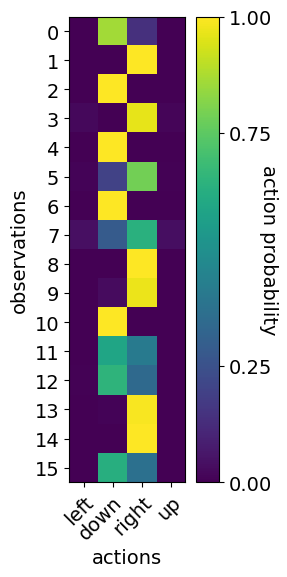

In [30]:
utils_02.plot_action_probs(action_probs)

Observa cómo el agente sólo se mueve hacia abajo y hacia la derecha en el Lago Helado no resbaladizo.

Notas:
    
Observa cómo el agente sólo se mueve hacia abajo y hacia la derecha. Esto se debe a que estamos utilizando el lago congelado no resbaladizo. En este caso, el agente puede simplemente moverse desde el principio hasta el final sin que nada vaya mal. Por lo tanto, no hay necesidad de moverse hacia arriba o hacia la izquierda.

#### Visualizar las probabilidades de acción

Podemos visualizar estas probabilidades de acción superponiéndolas al mapa del Lago Congelado:

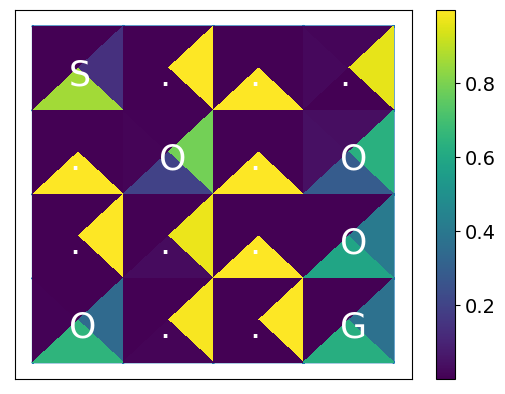

In [31]:
utils_02.q_state_action_plot_frozenlake(action_probs_df.values, env)

Notas:

Observa cómo el agente tiene a menudo probabilidades muy cercanas a 1 (amarillo). Está claro que quiere caminar hacia la meta. Las probabilidades de los estados de agujero o meta están menos definidas porque los episodios terminan allí. El agente suele empezar moviéndose hacia abajo, pero a veces se mueve hacia la derecha, con lo que también llega a la meta 

En el Módulo 4 hablaremos de algo llamado factor de descuento, que explica por qué al agente no le gusta perder el tiempo caminando hacia el borde del mapa.

#### Lago helado resbaladizo

Comparemos lo anterior con el resbaladizo Lago Helado, restaurando en su lugar un agente entrenado en ese env:

In [32]:
ppo_slip = ppo_config.environment(env_config={"is_slippery" : True}).build("FrozenLake-v1")
env_slip = gym.make("FrozenLake-v1", is_slippery=True)

In [33]:
ppo_slip.restore("models/FrozenLakeSlippery-3232-Ray2/checkpoint_000060")

In [34]:
action_probs_slip = {obs : utils_02.query_policy(ppo_slip, env_slip, obs) for obs in range(16)}
action_probs_slip_df = pd.DataFrame(action_probs_slip, index=["left", "down", "right", "up"]).T

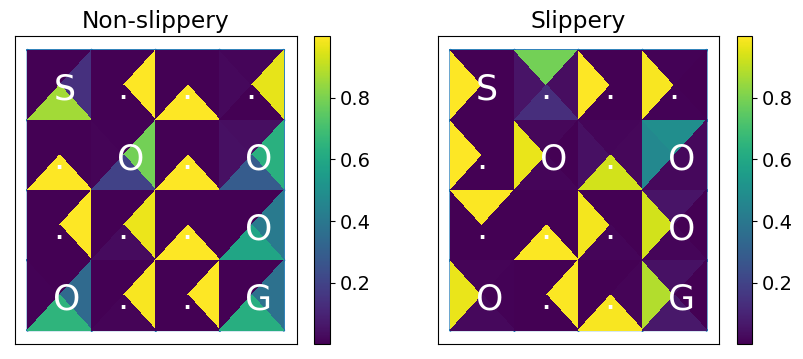

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
utils_02.q_state_action_plot_frozenlake(action_probs_df.values, env)
plt.title("Non-slippery")
plt.subplot(1,2,2)
utils_02.q_state_action_plot_frozenlake(action_probs_slip_df.values, env_slip)
plt.title("Slippery")

Notas:

Vamos a compararlas una al lado de la otra. Anteriormente hablamos del lago helado no resbaladizo, en el que el agente camina hacia la meta de forma sencilla. En el lago helado resbaladizo, el agente se comporta de forma poco intuitiva al principio, eligiendo a menudo caminar hacia la pared. Sin embargo, tras una inspección más detallada, vemos que esto es para evitar caer en los agujeros.  Por ejemplo, en la posición 10 se mueve hacia la izquierda para evitar cualquier posibilidad de caer en el agujero de la posición 11. Sin embargo, ¿por qué el agente se mueve hacia abajo en la posición 14? ¿Por qué no a la derecha? Responderemos a esta pregunta en el módulo 5, cuando hablemos de los valores Q. ¡Estáte atento! La respuesta breve es que prefiere evitar la ubicación 10, porque la ubicación 10 tiene que evitar la ubicación 11, que es una molestia porque tiene que moverse a la ubicación 9 

También podemos ver que este agente se comporta de forma bastante determinista, es decir, para cada estado suele haber una acción con probabilidad cercana a 1. A continuación exploraremos esto un poco más.

#### Actuación estocástica

- Anteriormente vimos las probabilidades de acción de nuestro agente no resbaladizo.
- Podemos comprobar que `compute_single_action` actuará según estas probabilidades:

In [36]:
action_probs[0]

array([3.0708601e-04, 8.6194783e-01, 1.3743131e-01, 3.1362689e-04],
      dtype=float32)

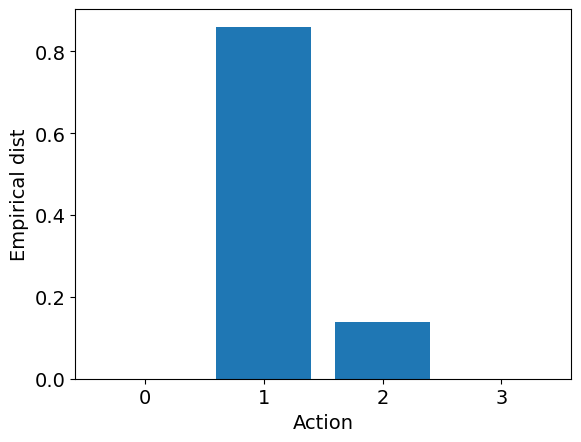

In [37]:
counts = np.bincount([ppo.compute_single_action(0) for _ in range(10_000)])
plt.bar([0,1,2,3], counts/10_000)
plt.xticks([0,1,2,3])
plt.xlabel("Action")
plt.ylabel("Empirical dist")

#### Actuar de forma determinista

También podemos decirle al agente que actúe de forma determinista con `explorar=False`:

In [38]:
ppo.compute_single_action(0, explore=False)

1

In [39]:
print([ppo.compute_single_action(0, explore=False) for _ in range(100)])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


A menudo esto es deseable, pero **a veces la política óptima es estocástica**.

Notas:

Durante el entrenamiento, la exploración es un concepto fundamental en la VR. ¡Lo discutiremos en el Módulo 4!

En el Módulo 4 también veremos un ejemplo en el que la política óptima es estocástica, por lo que definitivamente no querremos establecer `explorar=False` en la implementación.

#### ¡Apliquemos lo que hemos aprendido!

## Sintaxis de configuración de RLlib
<!-- multiple choice -->

¿Cuál de las siguientes es **NO** la sintaxis RLlib correcta para instanciar una instancia del algoritmo PPO? Supón que ya se ha ejecutado la siguiente importación:

``python
from ray.rllib.algorithms.ppo import PPO, PPOConfig
```

- [ ] PPOConfig().build(env='FrozenLake-v1')
- [ ] PPOConfig().environment(env='FrozenLake-v1').build()
- [x] PPOConfig(env='FrozenLake-v1').build()
- [ ] PPO(env='FrozenLake-v1')

In [40]:
# # HIDDEN - TO TEST THE ABOVE QUESTION
# from ray.rllib.algorithms.ppo import PPO, PPOConfig

# PPOConfig().framework("torch").build(env="FrozenLake-v1")
# PPOConfig().framework("torch").environment(env="FrozenLake-v1").build()
# PPO(env="FrozenLake-v1", config={"framework" : "torch"})
# PPOConfig(env="FrozenLake-v1").framework("torch").build()

## Guardar/restaurar modelos
<!-- multiple choice -->

¿Cuál de los siguientes es **NO** un uso plausible de guardar ("checkpointing") modelos en RLlib?

- [x] El checkpointing genera criptomonedas.
- [ ] En un curso como éste, cargar un punto de control significa que no tienes que esperar siempre a que los modelos se entrenen.
- [ ] Los modelos guardados pueden almacenarse, compartirse, copiarse y/o trasladarse para su despliegue.
- [ ] El entrenamiento puede reanudarse desde un punto de control en caso de que falle y sea necesario reiniciarlo.

## Entorno de la cesta de la compra
<!-- coding exercise -->

Un entorno de referencia famoso en RL es el entorno _Cartpole_, en el que el agente debe equilibrar un [péndulo invertido](https://en.wikipedia.org/wiki/Inverted_pendulum) aplicando fuerza sobre el carro (en la parte inferior) para mantenerlo estable. Hay más información en la documentación del gimnasio [aquí](https://www.gymlibrary.ml/environments/classic_control/cart_pole/).

Completa el código para que restaure el modelo entrenado desde el punto de control y luego renderice el entorno con el agente entrenado.

Nota: el código que sigue importa el entorno `MyCartPole`. Es idéntica a la de gym `'CartPole-v1`, salvo que se ha anulado el método de renderización con algo que se puede mostrar dentro de esta plataforma de curso interactivo 

In [41]:
# EXERCISE
import numpy as np
import time
from IPython import display

from envs_02 import MyCartPole
from ray.rllib.algorithms.ppo import PPO, PPOConfig

config = (
    ____()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32,32]})
)

ppo = ____.____(env=MyCartPole)

____.restore("models/CartPole-Ray2/checkpoint_000050")

env = MyCartPole()
obs = env.reset()
done = False
while not done:
    action = ppo.compute_single_action(obs)
    obs, reward, done, _ = env.step(action)

    env.render()
    time.sleep(0.01)

display.clear_output(wait=True)

NameError: name '____' is not defined

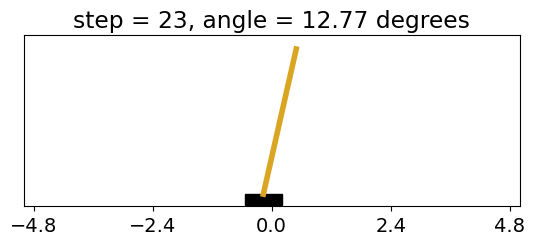

In [42]:
# SOLUTION
import numpy as np
import time
from IPython import display

from envs_02 import MyCartPole
from ray.rllib.algorithms.ppo import PPO, PPOConfig

config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32,32]})
)

ppo = config.build(env=MyCartPole)

ppo.restore("models/CartPole-Ray2/checkpoint_000050")

env = MyCartPole()
obs = env.reset()
done = False
while not done:
    action = ppo.compute_single_action(obs)
    obs, reward, done, _ = env.step(action)

    env.render()
    time.sleep(0.01)

display.clear_output(wait=True)

## Entorno de los cartuchos continuado
<!-- coding exercise -->

Continuando con el entorno CartPole
en este ejercicio exploraremos el comportamiento del agente entrenado utilizando la función
función `utils_02.query_Policy` de las diapositivas. En el caso de CartPole
el espacio de observación es continuo, pero el espacio de acción es discreto con sólo dos
posibilidades (empujar a la izquierda o empujar a la derecha). Por tanto, sólo podemos observar la
probabilidad de que el agente empuje a la izquierda, ya que P(derecha) = 1 - P(izquierda).
El espacio de acción contiene 4 variables continuas (ángulo del poste, velocidad angular
posición horizontal del carro, velocidad horizontal del carro), pero nos centraremos sólo en
el ángulo del poste. El resultado es un gráfico de P(izquierda) frente al ángulo del poste
(donde los otros tres valores de observación se fijan en cero).
Ejecuta el código y luego responde a la pregunta de opción múltiple que aparece a continuación.

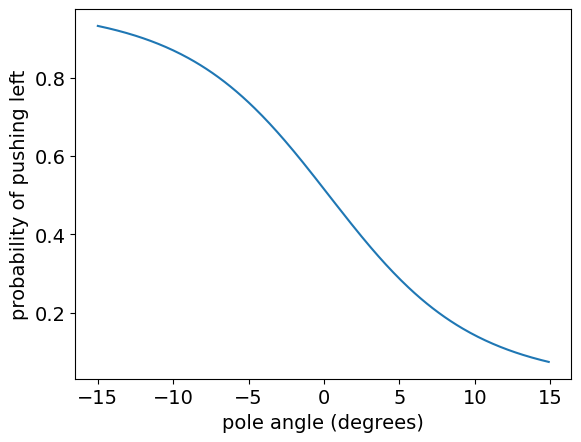

In [43]:
# EXERCISE
import numpy as np
import matplotlib.pyplot as plt

import utils_02
import envs_02

cartpole_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env=envs_02.MyCartPole)
)

ppo = cartpole_config.build()

ppo.restore("models/CartPole-Ray2/checkpoint_000050")

angle_range_deg = np.arange(-15,15,0.1)
push_left_probs = 0*angle_range_deg

env = envs_02.MyCartPole()
obs = env.reset()
for i, angle_deg in enumerate(angle_range_deg):
    angle_rad = angle_deg/180*np.pi
    
    obs = np.zeros(4)
    obs[2] = angle_rad

    push_left_probs[i] = utils_02.query_policy(ppo, env, obs, actions=[0,1])[0]

plt.plot(angle_range_deg, push_left_probs)
plt.xlabel("pole angle (degrees)")
plt.ylabel("probability of pushing left")

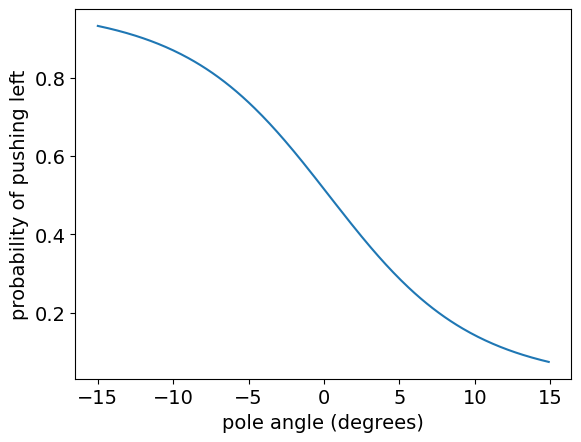

In [44]:
# SOLUTION
import numpy as np
import matplotlib.pyplot as plt

import utils_02
import envs_02

cartpole_config = (
    PPOConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
    .environment(env=envs_02.MyCartPole)
)

ppo = cartpole_config.build()

ppo.restore("models/CartPole-Ray2/checkpoint_000050")

angle_range_deg = np.arange(-15,15,0.1)
push_left_probs = 0*angle_range_deg

env = envs_02.MyCartPole()
obs = env.reset()
for i, angle_deg in enumerate(angle_range_deg):
    angle_rad = angle_deg/180*np.pi
    
    obs = np.zeros(4)
    obs[2] = angle_rad

    push_left_probs[i] = utils_02.query_policy(ppo, env, obs, actions=[0,1])[0]

plt.plot(angle_range_deg, push_left_probs)
plt.xlabel("pole angle (degrees)")
plt.ylabel("probability of pushing left")

#### Interpretación de la trama

¿Cómo afecta el ángulo del poste observado a la probabilidad del agente entrenado de empujar hacia la izquierda?

- [ ] Los ángulos de poste positivos (inclinados hacia la derecha) hacen que el agente tenga más probabilidades de empujar el carro hacia la izquierda. | Ten en cuenta que el agente quiere empujar el carro por debajo de la parte superior del poste.
- [x] Los ángulos negativos del poste (inclinados hacia la izquierda) hacen que el agente tenga más probabilidades de empujar el carro hacia la izquierda.
- [ ] La probabilidad de que el agente empuje hacia la izquierda no se ve afectada significativamente por el ángulo del poste.
- [ ] Ninguna de las anteriores.